In [ ]:
import numpy as np
import sympy as sp

#https://wilselby.com/research/arducopter/modeling/
#https://en.wikipedia.org/wiki/Motor_constants

In [9]:
#Define rotation matrices

phi = sp.symbols("phi", real = True) #roll angle (rad)
theta = sp.symbols("theta", real = True) #pitch angle (rad)
psi = sp.symbols("psi", real = True) #yaw angle (rad)

rot_psi = sp.Matrix([
    [sp.cos(psi), sp.sin(psi), 0],
    [-sp.sin(psi), sp.cos(psi), 0],
    [0, 0, 1]
])

rot_theta = sp.Matrix([
    [sp.cos(theta), 0, -sp.sin(theta)],
    [0, 1, 0],
    [sp.sin(theta), 0, sp.cos(theta)]
])

rot_phi = sp.Matrix([
    [1, 0, 0],
    [0, sp.cos(phi), sp.sin(phi)],
    [0, -sp.sin(phi), sp.cos(phi)]
])

#body_coord = R_G_b * X_G = R(phi) * R(theta) * R(psi) * X_G
R_global_body = rot_phi @ rot_theta @ rot_psi

#global_coord = R_b_G * x_b = R(phi)t * R(theta)t * R(psi)t * x_b
R_body_global = R_global_body.T

In [54]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

class quadcopter:
    def __init__(self, mass, Ixx, Iyy, Izz, K_t, K_d, g, length, charge, K_v, K_tor):
        
        #Mass and inertias
        self.mass = mass
        self.Ixx = Ixx
        self.Iyy = Iyy
        self.Izz = Izz
        self.I_matrix = sp.Matrix([
            [Ixx, 0, 0],
            [0, Iyy, 0],
            [0, 0, Izz]
        ])
        
        #Rotation and thrust arrays: Left, bottom, right, top
        self.K_t = K_t #thrust coefficient
        self.K_d = K_d #drag proportionality constant
        self.omega_mag_arr = np.zeros(4)
        self.thrust_mag_arr = np.zeros(4)
        self.torque_mag_arr = np.zeros(4)
        
        #Rotor distance from center
        self.length = length
        
        #position and velocity
        self.position = np.array([0.0, 0.0, 0.0]) #m
        self.velocity = np.array([0.0, 0.0, 0.0]) #m
        
        #Angles for attitude
        self.phi = 0 #roll angle (rad)
        self.theta = 0 #pitch angle (rad)
        self.psi = 0 #yaw angle (rad)
        
        #Angular velocities rates
        self.p = 0 #roll rate (rad/s)
        self.q = 0 #pitch rate (rad/s)
        self.r = 0 #yaw rate (rad/s)
        
        #Force of gravity and air density
        self.force_g = np.array([0, 0, -mass * g])
        
        #Battery characteristics
        self.charge = charge #Battery capcity in WHr
        self.K_v = K_v #Back EMF coefficient, inverse of motor velocity
        self.K_tor = K_tor #torque coefficient
        self.charge_used = 0 #Record how much charge you've used
        self.power_draw = 0 #Record how much power is being drawn
        
    
    def reset(self):
        #position and velocity
        self.position = np.array([0.0, 0.0, 0.0]) #m
        self.velocity = np.array([0.0, 0.0, 0.0]) #m
        
        #Angles for attitude
        self.phi = 0 #roll angle (rad)
        self.theta = 0 #pitch angle (rad)
        self.psi = 0 #yaw angle (rad)
        
        #Angular velocities rates
        self.p = 0 #roll rate (rad/s)
        self.q = 0 #pitch rate (rad/s)
        self.r = 0 #yaw rate (rad/s)
        
    def update_thrust(self):
        for i in range(4):
            self.thrust_mag_arr[i] = self.omega_mag_arr[i]**2 * self.K_t
    
    def update_power(self, dt, power_draw_arr, charge_used_arr):
        self.power_draw = 0
        for i in range(4):
            self.torque_mag_arr[i] = self.thrust_mag_arr[i] * self.K_tor
            self.power_draw += self.K_v * np.abs(self.torque_mag_arr[i]) * np.abs(self.omega_mag_arr[i]) / self.K_t
        self.charge_used += self.power_draw * dt
        power_draw_arr.append(self.power_draw)
        charge_used_arr.append(self.charge_used)
    
    def plot_power(self, t_arr, power_draw_arr, charge_used_arr):
        fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8, 6), tight_layout = True)
        
        axes[0].plot(t_arr, power_draw_arr)
        axes[0].set_title("Power Drawn vs Time")
        axes[0].set_xlabel("Time")
        axes[0].set_ylabel("Watts")
        
        axes[1].plot(t_arr, charge_used_arr)
        axes[1].set_title("Total Charge Used vs Time")
        axes[1].set_xlabel("Time")
        axes[1].set_ylabel("Watt Seconds")
        
    def net_forces_torques(self, heading):
        #update thrust with current rotation rates
        self.update_thrust()
        
        #Initiate net force
        net_force = np.array([0.0, 0.0, 0.0])
        
        #Add in gravity
        net_force += self.force_g
        
        #Rotation from body to global coordinate accelerations
        R_body_global_inst = R_body_global.subs({theta: self.theta, phi: self.phi, psi: self.psi}).evalf()
        
        #Include the rotation from velocity heading, line x-axis up with heading
        R_heading = np.array([
            [heading[0], -heading[1], 0],
            [heading[1], heading[0], 0],
            [0, 0, 1]
        ])
        
        #transfer forces to global frame
        for thrust in self.thrust_mag_arr:
            thrust_vec = np.array([0, 0, thrust])
            thrust_vec_rotated = np.array(R_heading @ R_body_global_inst @ thrust_vec, dtype=np.float64)
            net_force += thrust_vec_rotated
        
        #Get net torque
        net_torque = np.array([
            self.length * self.K_t * (self.omega_mag_arr[3]**2 - self.omega_mag_arr[1]**2),
            self.length * self.K_t * (self.omega_mag_arr[2]**2 - self.omega_mag_arr[0]**2),
            self.K_d * (self.omega_mag_arr[0]**2 - self.omega_mag_arr[1]**2 + self.omega_mag_arr[2]**2 - self.omega_mag_arr[3]**2)
        ])

        return net_force, net_torque

    def find_accels(self, net_force, net_torque):
        #linear acceleration x, y, z (m/s2)
        linear_accel = net_force / self.mass
        
        #rotational acceleration phi, theta, psi (rad/s2)
        rotation_accel = np.array([
            ((self.Iyy - self.Izz) * self.q * self.r - net_torque[0]) / self.Ixx,
            ((self.Izz - self.Ixx) * self.p * self.r + net_torque[1]) / self.Iyy, 
            ((self.Ixx - self.Iyy) * self.p * self.q + net_torque[2]) / self.Izz
        ])
        
        return linear_accel, rotation_accel
        
    def plot_ledgers(self, limit, t_ledger, x_ledger, y_ledger, z_ledger, phi_ledger, theta_ledger, psi_ledger):
        fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 6), tight_layout = True)
        axes[0, 0].plot(t_ledger, x_ledger)
        axes[0, 0].set_ylim(-limit, limit)
        axes[0, 0].set_title("X vs time")
        
        axes[0, 1].plot(t_ledger, y_ledger)
        axes[0, 1].set_ylim(-limit, limit)
        axes[0, 1].set_title("Y vs time")
        
        axes[0, 2].plot(t_ledger, z_ledger)
        axes[0, 2].set_ylim(-limit, limit)
        axes[0, 2].set_title("Z vs time")
        
        axes[1, 0].plot(t_ledger, phi_ledger)
        axes[1, 0].set_title("roll vs time")
        
        axes[1, 1].plot(t_ledger, theta_ledger)
        axes[1, 1].set_title("pitch vs time")
        
        axes[1, 2].plot(t_ledger, psi_ledger)
        axes[1, 2].set_title("yaw vs time")    
    
    def defy_gravity(self):
        h = 1.0
        self.position = np.array([0.0, 0.0, h])
        
        omega_mag = np.sqrt(-self.force_g[2] / 4 / self.K_t)
        self.omega_mag_arr[0] = omega_mag
        self.omega_mag_arr[1] = -omega_mag
        self.omega_mag_arr[2] = omega_mag
        self.omega_mag_arr[3] = -omega_mag

        t = 0
        dt = 0.01
        x_ledger = [self.position[0]]
        y_ledger = [self.position[1]]
        z_ledger = [self.position[2]]
        phi_ledger = [self.phi]
        theta_ledger = [self.theta]
        psi_ledger = [self.psi]
        t_ledger = [0]
        heading = np.array([1, 0, 0])
        
        power_draw_ledger = []
        charge_used_ledger = []
        
        while t <= 10:
            net_force, net_torque = self.net_forces_torques(heading)
            self.update_power(dt, power_draw_ledger, charge_used_ledger)
            lin_accel, rot_accel = self.find_accels(net_force, net_torque)
            
            self.position += self.velocity * dt
            self.velocity += lin_accel * dt
            
            self.phi += self.p * dt
            self.theta += self.q * dt
            self.psi += self.r * dt
            
            self.p += rot_accel[0] * dt
            self.q += rot_accel[1] * dt
            self.r += rot_accel[2] * dt
            
            x_ledger.append(self.position[0])
            y_ledger.append(self.position[1])
            z_ledger.append(self.position[2])
            phi_ledger.append(self.phi)
            theta_ledger.append(self.theta)
            psi_ledger.append(self.psi)
            
            t += dt
            t_ledger.append(t)
        self.plot_ledgers(2, t_ledger, x_ledger, y_ledger, z_ledger, phi_ledger, theta_ledger, psi_ledger)
        self.plot_power(t_ledger[1:], power_draw_ledger, charge_used_ledger)
        
    def circle(self, radius, speed):
        
        #Initiate position and velocity
        self.position = np.array([2.0, 0.0, 1.0])
        self.velocity = np.array([0.0, 0.5, 0.0])
        
        #solve for roll angle
        a_radial = -speed**2 / radius
        a_down = 9.81
        self.phi = np.arctan2(a_radial, a_down)
        
        #solve for rotation speed of rotors
        thrust_mag_needed = self.mass * np.sqrt(a_down**2 + a_radial**2)
        omega_mag = np.sqrt(thrust_mag_needed / 4 / self.K_t)
        self.omega_mag_arr[0] = omega_mag
        self.omega_mag_arr[1] = -omega_mag
        self.omega_mag_arr[2] = omega_mag
        self.omega_mag_arr[3] = -omega_mag       
        
        #Initiate ledgers
        t = 0
        dt = 0.01
        x_ledger = [self.position[0]]
        y_ledger = [self.position[1]]
        z_ledger = [self.position[2]]
        vx_ledger = [self.velocity[0]]
        vy_ledger = [self.velocity[1]]
        vz_ledger = [self.velocity[2]]
        phi_ledger = [self.phi]
        theta_ledger = [self.theta]
        psi_ledger = [self.psi]
        t_ledger = [0]
        
        power_draw_ledger = []
        charge_used_ledger = []
        
        #Initiate heading
        heading = self.velocity / np.linalg.norm(self.velocity)
        
        #Time step forward for 10 seconds
        while t <= 70:
            net_force, net_torque = self.net_forces_torques(heading)
            self.update_power(dt, power_draw_ledger, charge_used_ledger)
            lin_accel, rot_accel = self.find_accels(net_force, net_torque)

            self.velocity += lin_accel * dt
            self.position += self.velocity * dt
            
            heading = self.velocity / np.linalg.norm(self.velocity)
            
            self.phi += self.p * dt
            self.theta += self.q * dt
            self.psi += self.r * dt
            
            self.p += rot_accel[0] * dt
            self.q += rot_accel[1] * dt
            self.r += rot_accel[2] * dt
            
            x_ledger.append(self.position[0])
            y_ledger.append(self.position[1])
            z_ledger.append(self.position[2])
            vx_ledger.append(self.velocity[0])
            vy_ledger.append(self.velocity[1])
            vz_ledger.append(self.velocity[2])
            phi_ledger.append(self.phi)
            theta_ledger.append(self.theta)
            psi_ledger.append(self.psi)
            
            t += dt
            t_ledger.append(t)
            
        self.plot_ledgers(radius * 1.25, t_ledger, x_ledger, y_ledger, z_ledger, phi_ledger, theta_ledger, psi_ledger)
        self.plot_power(t_ledger[1:], power_draw_ledger, charge_used_ledger)


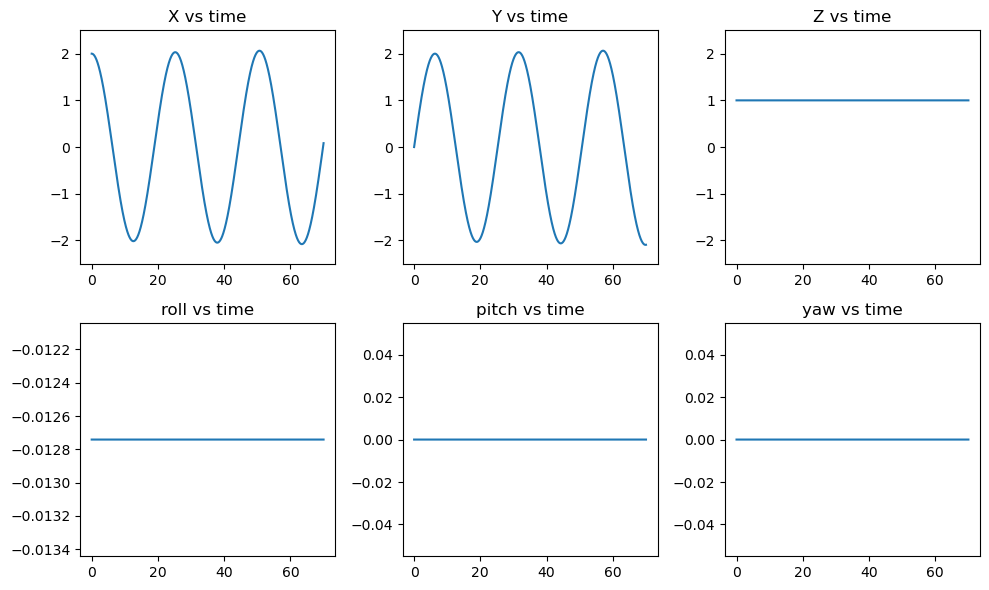

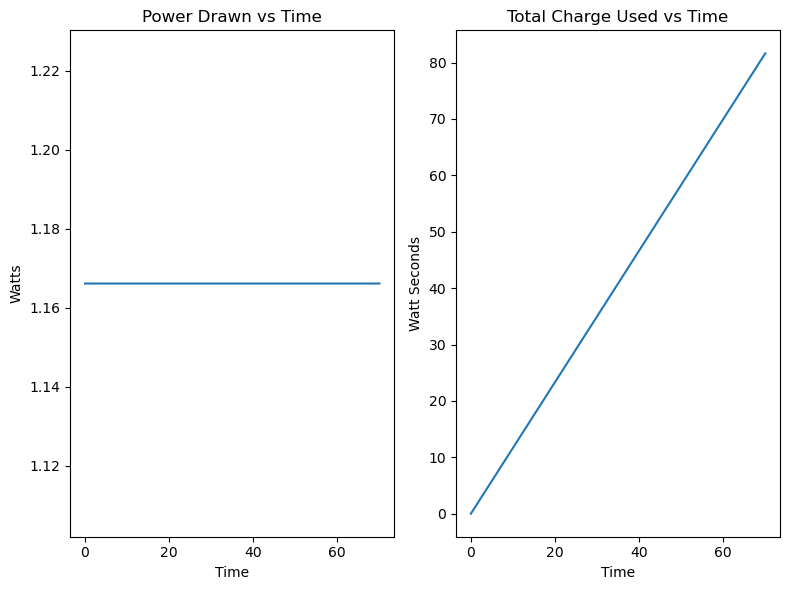

In [56]:
#mass, Ixx, Iyy, Izz, K_t, K_d, g, length, charge, K_v, K_tor
qc = quadcopter(5, 1, 1, 1, 0.5, 0.1, 9.81, 0.25, 20,  1 / 5000, 12)

#qc.defy_gravity()
qc.circle(2, 0.5)